# State Space models for Time Series

State space models are similar to the statistical models we looked at in the previous
chapter but with a more “real-world” motivation. They address concerns that emerge
in real-world engineering problems, such as how to factor in measurement error
when making estimates and how to inject prior knowledge or belief into estimates.

State space models posit a world in which the true state cannot be measured directly
but only inferred from what can be measured. State space models also rely on specify‐
ing the dynamics of a system, such as how the true state of the world evolves over
time, both due to internal dynamics and the external forces that are applied to a
system.

While you may not have seen state space models before in a mathematical context,
you have likely used them in your day-to-day life. For example, imagine you see a
driver weaving in traffic. You try to determine where the driver is going and how you
can best defend yourself. If the driver might be intoxicated, you would consider call‐
ing the police, whereas if the driver was temporarily distracted for a reason that won’t
repeat itself, you’d probably mind your own business. In the next few seconds or
minutes you would update your own state space model of that driver before deciding
what to do.

A classic example of where you would use a state space model is a rocket ship
launched into space. We know Newton’s laws, so we can write the rules for the
dynamics of the system and what the motion should look like over time. We also
know that our GPS or sensors or whatever we use to track location will have some
measurement error that we can quantify and attempt to factor into the uncertainty
about our calculations. Finally, we know that we can’t account for all the forces in the
world acting on a particular rocket as there are many unknowns in the system, so we
want a process that is robust to other unknown sources of noise, perhaps solar wind
or earthly wind or both. As it turns out, statistical and engineering advances in the
last 50 years have proven quite useful for tackling these sorts of situations.

Two different historical trends led to the development of state space models and
interest in the kinds of problems they address. First, around the middle of the 20th
century, we entered an age of mechanical automation. There were rockets and space‐
ships in the sky, navigation systems for submarines, and all sorts of other automated
inventions that required estimation of a system state that could not be measured. As
researchers thought about how to estimate system state, they began developing state
space methods, most importantly to disambiguate measurement errors from other
kinds of uncertainty in the system. This led to the first uses of state space methods.
During this time period, too, recordkeeping technology and associated computing
were also developing. This led to the creation of much larger data sets for time series,
including much longer or more detailed time series data sets. As more time series
data became available, more data-intensive methods could be developed for them in
conjunction with the new thinking about state space modeling.

In this chapter we will study these commonly used state space methods:
- The Kalman filter applied to a linear Gaussian model
- Hidden Markov Models
- Bayesian structural time series

In each of these cases, the use of such models is quite accessible and well imple‐
mented. For each model, we will develop some intuition for the mathematics and dis‐
cuss what kind of data is appropriate for use with the method. Finally, we will see
code examples for each method.

In each case we will distinguish between what we observe and the state that produced
our observations. In estimating the underlying state based on observations, we can
divide our work into different stages or categories:

_Filtering_
- Using the measurement at time t to update our estimation of the state at time t

_Forecasting_
- Using the measurement at time t – 1 to generate a prediction for the expected
state at time t (allowing us to infer the expected measurement at time t as well)

_Smoothing_
- Using measurement during a range of time that includes t, both before and after
it, to estimate what the true state at time t was

The mechanics of these operations will often be similar, but the distinctions are
important. Filtering is a way of deciding how to weigh the most recent information
against past information in updating our estimate of state. Forecasting is the
prediction of the future state without any information about the future. Smoothing is
the use of future and past information in making a best estimate of the state at a given
time.

## State Space Models: Pluses and Minuses

State space models can be used for both deterministic and stochastic applications,
and they can be applied to both continuously sampled data and discretely sampled
data.

There are many strengths of a state space model. A state space model allows for mod‐
eling what is often most interesting in a time series: the dynamic process and states
producing the noisy data being analyzed, rather than just the noisy data itself. With a
state space model, we inject a model of causality into the modeling process to explain
what is generating a process in the first place. This is useful for cases where we have
strong theories or reliable knowledge about how a system works, and where we want
our model to help us suss out more details about general dynamics with which we are
already familiar.

A state space model allows for changing coefficients and parameters over time, which
means that it allows for changing behavior over time. We did not impose a condition
of stationarity on our data when using state space models. This is quite different from
the models we examined in Chapter 6, in which a stable process is assumed and mod‐
eled with only one set of coefficients rather than time-varying coefficients.

Nonetheless, there are also some disadvantages to a state space model, and sometimes
the strength of the state space model is also its weakness:

- Because state space models are so flexible, there are many parameters to be set
    and many forms a state space model can take. This means that the properties of a
    particular state space model have often not been well studied. When you formu‐
    late a state space model tailored to your time series data, you will rarely have stat‐
    istical textbooks or academic research papers in which others have studied the
    model too. This leaves you in less certain territory as far as understanding how
    your model performs or where you may have committed errors.
    
- State space models can be very taxing computationally because there are many
    parameters. Also, the very high number of parameters for some kinds of state
    space models can leave you vulnerable to overfitting, particularly if you don’t
    have much data.

# The Kalman Filter

The Kalman filter is a well-developed and widely deployed method for incorporating
new information from a time series and incorporating it in a smart way with previ‐
ously known information to estimate an underlying state. One of first uses of the Kal‐
man filter was on the Apollo 11 mission—the filter was chosen when NASA
engineers realized that the onboard computing elements would not allow other, more
memory-intensive techniques of position estimation. As you will see in this section,
the benefits of the Kalman filter are that it is relatively easy to compute and does not
require storage of past data to make present estimates or future forecasts.

The mathematics of the Kalman filter can be intimidating to a newcomer, not
because it is especially difficult but because there are a fair number of quantities to
keep track of, and it’s an iterative, somewhat circular process with many related
quantities. For this reason, we will not derive the Kalman filter equations here, but
instead go through a high-level overview of those equations to get a sense of how they
work.

We begin with a linear Gaussian model, positing that our state and our observations
have the following dynamics:

$$ x_t = Fx_{t - 1} + B u_t + w_t $$

$$ y_t = A x_t + v_t $$

That is, the state at time t is a function of the state at the previous time step ($F x_{t–1 }$),
an external force term ($Bu_t$ ), and a stochastic term ($w_t$ ). Likewise, the measurement
at time t is a function of the state at time t and a stochastic error term, measurement
error.

Let’s imagine that $x_t$ is the real position of a spaceship, while $y_t$ is the position we
measure with a sensor. $v_t$ is the measurement error in our sensor device (or range of
devices). The fundamental equation applicable to the Kalman filter is this equation
illustrating how to update our estimation given new information for time $t$:


$$ \hat{x}_t = K_t y_t + (1 - K_t)\hat{x}_{t - 1}$$

What we see here is a filtering step—that is, a decision about how to use the measure‐
ment at time t to update our state estimation at time $t$. Remember, we have posited a
situation in which we can observe only y t and make inferences about the state but can
never be sure of the state exactly. We see above that the quantity K t establishes a bal‐
ance in our estimation between old information ( $\hat{x}_{t–1}$ ) and new information ($y_t$ ).

To go into the more detailed mechanics, we need to define some terms. We use $P_t$ t to
denote our estimate of the covariance of our state (this can be a scalar or a matrix,
depending on whether the state is univariate or multivariate, the latter being more
common). $P^{–}_t$ is the estimate for t before our measure at time t is taken into account.

We also use $R$ to denote the measurement error variance, that is the variance of $v_t$ ,
which again can either be a scalar or a covariance matrix depending on the dimen‐
sionality of the measurements. R is generally well defined for a system, as it describes
well-known physical properties of a particular sensor or measuring device. The appo‐
site value for $w_t$ , $Q$, is less well defined and subject to tuning during the modeling
process.

Then we begin with a process such that we have known or estimated values for $x$ and
$P$ at time 0. Then, going forward for times after time 0, we follow an iterative process
of a prediction and updating phase, with the prediction phase coming first, followed
by the update/filtering phase, and so on:

Prediction:

$$ \hat{x}^-_t = F \hat{x}_{t - 1} + B u_t $$

$$ P^-_t = F P_{t - 1} F^T + Q$$

Filtering:
$$ \hat{x}_t = \hat{x}^-_t + K_t (y_t - A\hat{x}^-_t)$$
$$ P^-_t = (I - K_t A) P^-_t$$

where $K_t$ the Kalman gain, is:

$$ K_t = P^-_t A^T (A P^-_t A^T + R^{-1}) $$

You will see many visualizations of this recursive process. Some will break this into
many steps, perhaps up to four or five, but the simplest way of thinking about it is
that there are the computations undertaken to predict the values at time t, without a
measurement for y t (the prediction), and then there are the steps undertaken at time
t, after the measurement y t is known (the filtering).
To start, you need the following values:

- Estimates for $R$ and $Q$—your covariance matrices for measurement error (easy to
know) and state stochasticity (usually estimated), respectively
- timates or known values for your state at time 0, $ \hat{x}_0 $ (estimated based on $y_0$ )
- vance knowledge of what forces are planned to be applied at time t and how
these impact state—that is, the matrix $B$ and the value $u_t$
- owledge of system dynamics that determine the state transition from one time
step to another, namely $F$
- owledge of how the measurement depends on the state, namely $A$

## Code for the Kalman Filter

We consider a classic use case: trying to track an object subject to Newton’s mechan‐
ics with error-prone sensors. We generate a time series based on Newton’s laws of
motion, namely that the position of an object is a function of its velocity and acceler‐
ation. We imagine taking discrete measurements even though the underlying move‐
ment is continuous. We first determine a series of accelerations, then assume that
both position and velocity begin at 0. While it is not physically realistic, we assume
instant acceleration changes at the beginning of each time step, and a steady accelera‐
tion value:

In [1]:
# rocket will take 100 time steps
ts_length <- 100

# acceleration will drive the motion
a <- rep(0.5, ts_length)

# position and velocity start at 0
x <- rep(0, ts_length)
v <- rep(0, ts_length)
for (ts in 2:ts_length) {
    x[ts] <- v[ts - 1] * 2 + x[ts - 1] + 1/2 * a[ts - 1] ^ 2
    x[ts] <- x[ts] + rnorm(1, sd = 20) # stochastic component
    v[ts] <- v[ts - 1] + 2 * a[ts - 1]
}

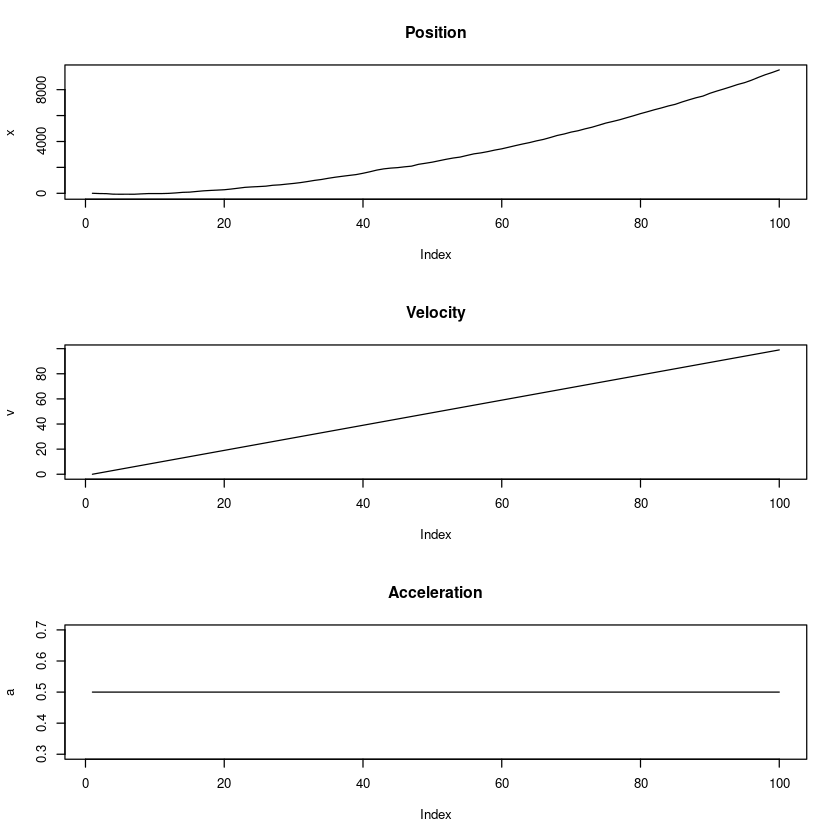

In [2]:
par(mfrow = c(3, 1))
plot(x, main = 'Position', type = 'l')
plot(v, main = 'Velocity', type = 'l')
plot(a, main = 'Acceleration', type = 'l')

We posit that these variables would represent a full description of the state, but that
the only data available to us is the object’s position and that this data is available only
from a noisy sensor. This sensor is x in the following code, and we plot how the
measured value relates to the actual position

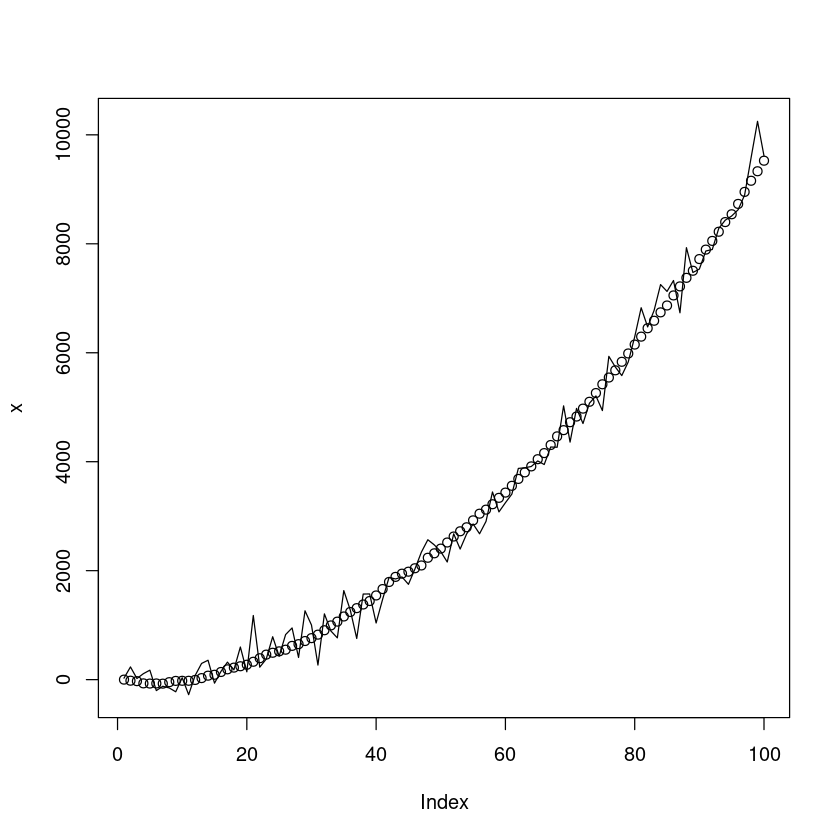

In [3]:
z <- x + rnorm(ts_length, sd = 300)
plot(x, ylim = range(c(x, z)))
lines(z)

Now we apply a Kalman filter. First, we code up a general function that reflects our
discussion and derivation earlier in this section:

In [4]:
kalman_motion <- function(z, Q, R, A, H) {
    dim_state = dim(Q)[1]
    x_hat_minus <- array(rep(0, ts_length * dim_state),
                         c(ts_length, dim_state))
    x_hat <- array(rep(0, ts_length * dim_state),
                   c(ts_length, dim_state))
    P_minus <- array(rep(0, ts_length * dim_state * dim_state),
                     c(ts_length, dim_state, dim_state))
    P <- array(rep(0, ts_length * dim_state * dim_state),
               c(ts_length, dim_state, dim_state))
    K <- array(rep(0, ts_length * dim_state),
              c(ts_length, dim_state)) # kalman gain
    # initial guesses = starting at 0 for all metrics
    x_hat[1, ] <- rep(0, dim_state)
    P[1, , ] <- diag(dim_state)
    # time updates
    for (k in 2:ts_length) {
        x_hat_minus[k, ] <- A %*% matrix(x_hat[k - 1, ])
        P_minus[k, , ] <- A %*% P[k - 1, , ] %*% t(A) + Q
        K[k, ] <- P_minus[k, , ] %*% H %*%
                                 solve(t(H) %*% P_minus[k, , ] %*% H + R)
        x_hat[k, ] <- x_hat_minus[k, ] + K[k, ] %*%
                                 (z[k] - t(H) %*% x_hat_minus[k, ])
        P[k, , ] <- (diag(dim_state) - K[k, ] %*% t(H)) %*% P_minus[k, , ]
    }
    # we return both the forecast and the smoothed value
    return(list(x_hat = x_hat, x_hat_minus = x_hat_minus))
}

We apply this function, making only the rocket’s position measurable (so not the
acceleration or velocity):

In [5]:
# noise parameters
R <- 10 ^ 2  # measurement variance
Q <- 10      # process variance
# dynamical parameters
A <- matrix(1)   # x_t = A * x_{t-1}
H <- matrix(1)   # y_t = H * x_t

In [6]:
# run the data thorugh the Kalman filtering emthod
x_hat <- kalman_motion(z, diag(1) * Q, R, A, H)[[1]]
x_hat_minus <- kalman_motion(z, diag(1) * Q, R, A, H)[[2]]

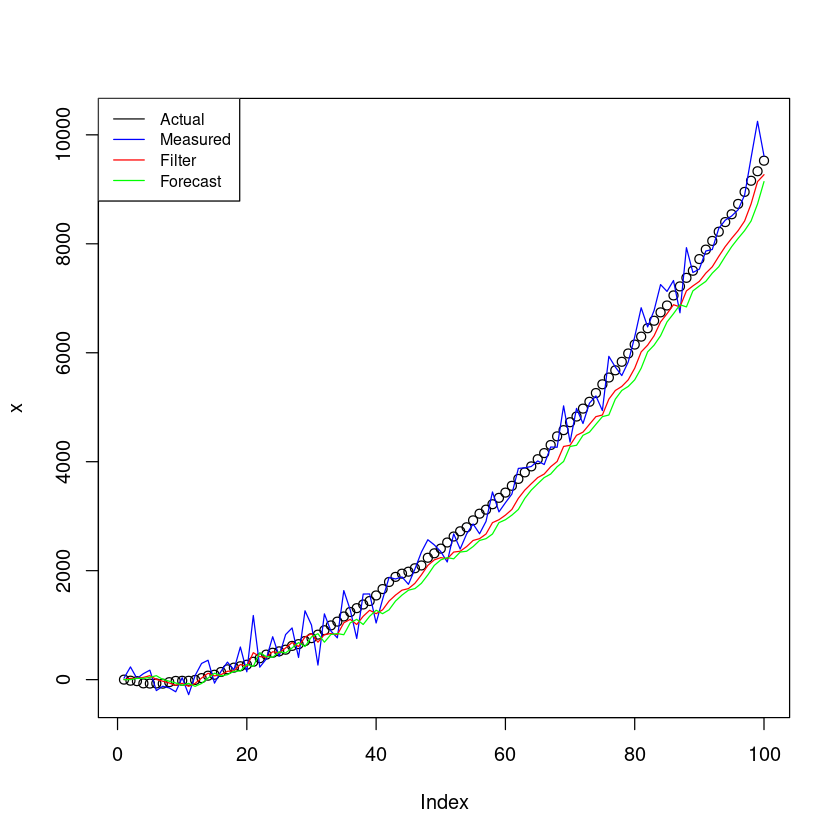

In [7]:
plot(x, ylim = range(c(x, z)))
lines(z, col = 'blue')
lines(x_hat, col = 'red')
lines(x_hat_minus, col = 'green')
legend("topleft", legend = c("Actual", "Measured", "Filter", "Forecast"),
       col = c("black", "blue", "red", "green"), lty = 1, cex = 0.8)

The Kalman filter takes out much of the noise from the measurement error. How
much it does so will depend on our value for R, the measurement noise parameter,
which reflects how much the filter should weigh the most recent value relative to ear‐
lier values. As we can see, the filter does a satisfactory job of forecasting the data. In
particular, note that there is not a lag between the forecast data and the actual data,
which would suggest that the method is merely predicting the current value based on
the last value.

Here we have worked through a simple example of a Kalman filter. The Kalman filter
is widely studied because it is so useful in a variety of applications, particularly those
where the internal dynamics of the system are very well understood. This makes it an

ideal tool in cases such as the simple rocket example, where we understand the
dynamics that are driving the system.
Note that in this simple example, the whole power and utility of the Kalman filter is
not fully realized. It is particularly useful when we have multiple kinds of measure‐
ments, say measuring different quantities or measuring the same thing simultane‐
ously with many devices. Also there are many extensions to the Kalman filter that are
worth studying if this is a promising area for your domain of interest.

One of the great benefits of the Kalman filter, as we’ve illustrated, is that it is recur‐
sive. This means that it is not necessary to look at all data points on each iteration of
the process. Rather, at each time step, all the information from prior time steps is
already incorporated in the best possible way in the few estimated parameters,
namely the most recent state and covariance estimate. The beauty of this method is
that we can update in a smart way just using these “summary statistics” like meas‐
ures, and we already know how to weigh them intelligently relative to the most recent
data. This makes the Kalman filter very useful for real-world applications where com‐
putational time or resources are at a premium. In many cases this also coincides with
the dynamics of real systems, in that the processes are relatively Markovian (memo‐
ryless other than the immediately prior state), and a function of an underlying state
that can only be measured with some error.

There are many useful extensions to the Kalman filter that we have not discussed
here. One principal use of the Kalman filter is to adapt it to smoothing, which means
using data both before and after time t to make the best estimate of the true state at
time t. The mathematics and code are similar to what has been presented already.
Also similar is the Extended Kalman Filter (EKF), which adapts the Kalman filter to
data with nonlinear dynamics. This is also relatively straightforward to implement
and is widely available in a variety of R and Python packages.

The Kalman filter is O(T) with respect to the length of the time series but O(d 2 ) with
respect to d, the dimension of the state. For this reason, it is important not to over-
specify the state when a more streamlined specification will do just as well. However,
it is this linearity with respect to the length of the time series that makes the Kalman
filter commonly used in real production scenarios and much more popular than
other filters developed for the purpose of state space modeling of time series.

# Hidden Markov Models